<a href="https://colab.research.google.com/github/trevorobrien/reimagined-octo-guide/blob/main/footie_shirts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import everything

import tensorflow as tf
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt

In [2]:
# mount gdrive

from google.colab import drive
import os
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
# count & display random training image

import pathlib
import PIL
import PIL.Image

data_dir = pathlib.Path('gdrive/MyDrive/ml/shirts/') 
data_dir = pathlib.Path(data_dir)
count = len(list(data_dir.glob('*/*.jpeg')))
print(count)

images = list(data_dir.glob('one/*'))

PIL.Image.open(str(images[1]))

720


In [4]:
# set image training dataset

batch_size = 720
img_height = 28
img_width = 28


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "rgb")

Found 720 files belonging to 1 classes.
Using 576 files for training.


In [5]:
# set image validation dataset


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "rgb")

Found 720 files belonging to 1 classes.
Using 144 files for validation.


In [6]:
# show classes in training set 


class_names = train_ds.class_names
print(class_names)

['one']


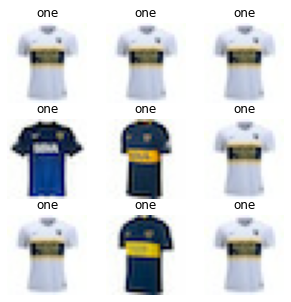

In [7]:
# display grid of images and confirm data is loaded correctly

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
# iterate through and print shape details

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(576, 28, 28, 3)
(576,)


In [9]:
# underscore to omit the label arrays
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() 

# image_batch = image_batch.reshape(image_batch.shape[0], 28, 28, 1).astype('float32')
# image_batch.reshape((-1, 1, 28, 28))
image_batch = tf.reshape(image_batch,[-1, 28,28,3])
image_batch = (image_batch - 127.5) / 127.5 # Normalize the images to [-1, 1]

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 72
BATCH_SIZE = 16

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(image_batch).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


11490434/11490434 [==============================] - 0s 0us/step


In [10]:
# iterate through and print shape details

for image_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 28, 28, 3)
(576,)


In [11]:

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
  
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)
    return model

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

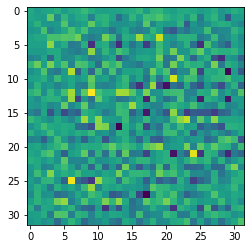

In [13]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0])

In [14]:

def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3], name='test1'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 test1 (Conv2D)              (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [16]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00467573]], shape=(1, 1), dtype=float32)


In [23]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [24]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [25]:
EPOCHS = 100
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 8
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [26]:
# tf.function annotation causes the function 
# to be "compiled" as part of the training
@tf.function
def train_step(images):
  
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).
    
    # It accepts a target (e.g., gen_loss) variable and 
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors  
    # (or IndexedSlices, or None), one for each element in sources. 
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [27]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch, 
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 3 - Save the model every 5 epochs as 
    # a checkpoint, which we will use later
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [28]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [29]:
train(train_dataset, EPOCHS)

ValueError: ignored